In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
#import pandas_profiling
from pydantic_settings import BaseSettings
%matplotlib inline
df = pd.read_csv('framingham.csv')

/var/folders/_5/727fvmnd5yd54mwrh313s9600000gn/T/ipykernel_42147/3651101966.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['BPMeds'].fillna(0, inplace = True)
/var/folders/_5/727fvmnd5yd54mwrh313s9600000gn/T/ipykernel_42147/3651101966.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

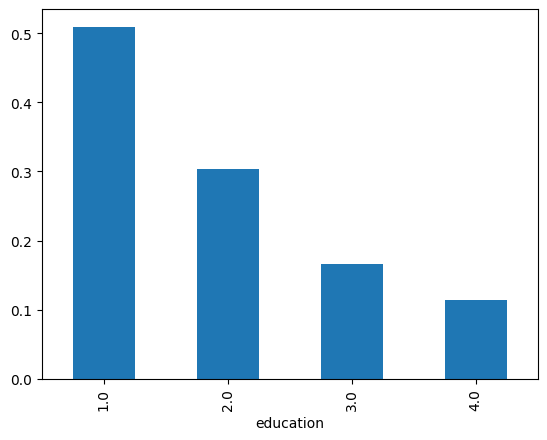

In [36]:
df['TenYearCHD'].value_counts(normalize = True)
df['cigsPerDay'].value_counts(normalize = True).plot(kind="bar")
df['cigsPerDay'][df['currentSmoker']==0].isna().sum()
# creating a boolean array of smokers
smoke = (df['currentSmoker']==1)
# applying mean to NaNs in cigsPerDay but using a set of smokers only
df.loc[smoke,'cigsPerDay'] = df.loc[smoke,'cigsPerDay'].fillna(df.loc[smoke,'cigsPerDay'].mean())
df['cigsPerDay'][df['currentSmoker']==1].mean()
df['cigsPerDay'][df['currentSmoker']==0].mean()
df['education'].value_counts(normalize = True).plot(kind="bar")
# Filling out missing values
df['BPMeds'].fillna(0, inplace = True)
df['glucose'].fillna(df.glucose.mean(), inplace = True)
df['totChol'].fillna(df.totChol.mean(), inplace = True)
df['education'].fillna(1, inplace = True)
df['BMI'].fillna(df.BMI.mean(), inplace = True)
df['heartRate'].fillna(df.heartRate.mean(), inplace = True)
df.isna().sum()

In [37]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# separate independent & dependent variables
X = df.iloc[:,0:14]  #independent columns
y = df.iloc[:,-1]    #target column i.e CHD



In [38]:
from sklearn.model_selection import train_test_split

y = df['TenYearCHD'] #target variable
X = df.drop(['TenYearCHD'], axis = 1) #features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(3392, 15) (3392,)
(848, 15) (848,)


# ECE228 optimization: MLP

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


# 1. Configurable MLP Model
class ConfigurableMLP(nn.Module):
    # Note this is supposed to be a binary classification task, bacause the target output "10 year CHD" is 
    # either 1 or 0
    def __init__(self, input_dim, hidden_dim, num_hidden_layers=2,
                 activation='relu', dropout_rate=0.0):
        super().__init__()

        # Choose activation function
        if activation == 'relu':
            activation_fn = nn.ReLU()
        elif activation == 'sigmoid':
            activation_fn = nn.Sigmoid()
        elif activation == 'tanh':
            activation_fn = nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation_fn)

        # Hidden layers
        for _ in range(num_hidden_layers):
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation_fn)

        # Output layer (for binary classification — change if needed)
        layers.append(nn.Linear(hidden_dim, 1))  # output logits
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# 2. train model
def train_model(
    X_train, y_train, X_val, y_val,
    input_dim,
    hidden_dim=64,
    num_hidden_layers=2,
    activation='relu',
    dropout_rate=0.0,
    learning_rate=1e-3,
    batch_size=32,
    epochs=100,
    use_l1=False,
    l1_lambda=1e-5,
    use_l2=False,
    l2_lambda=1e-4,
    early_stopping_patience=10
):
    # Build model
    model = ConfigurableMLP(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        num_hidden_layers=num_hidden_layers,
        activation=activation,
        dropout_rate=dropout_rate if dropout_rate > 0 else 0.0
    )

    # Set optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                           weight_decay=l2_lambda if use_l2 else 0.0)

    # Use BCEWithLogitsLoss for binary classification with logits
    criterion = nn.BCEWithLogitsLoss()

    # DataLoader setup
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

    best_val_loss = float('inf')
    patience_counter = early_stopping_patience
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb.view(-1, 1))


            if use_l1:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                output = model(xb)
                val_loss += criterion(output, yb.view(-1,1)).item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {total_loss:.4f}, Val Loss = {val_loss:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = early_stopping_patience
            best_model_state = model.state_dict()
        else:
            patience_counter -= 1
            if patience_counter == 0:
                print("Early stopping triggered.")
                break

    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model





In [44]:
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


In [47]:
trained_model = train_model(
    X_train, y_train,
    X_val, y_val,
    input_dim=X_train.shape[1],
    hidden_dim=64,
    num_hidden_layers=3,
    activation='relu',
    dropout_rate=0.2,
    learning_rate=1e-3,
    use_l1=False,
    use_l2=True,
    l1_lambda=1e-5,
    l2_lambda=1e-4,
    early_stopping_patience=10
)


Epoch 1/100: Train Loss = 48.4705, Val Loss = 0.3964
Epoch 2/100: Train Loss = 41.8203, Val Loss = 0.3852
Epoch 3/100: Train Loss = 41.8847, Val Loss = 0.3834
Epoch 4/100: Train Loss = 41.2281, Val Loss = 0.3815
Epoch 5/100: Train Loss = 40.7679, Val Loss = 0.3822
Epoch 6/100: Train Loss = 40.2413, Val Loss = 0.3847
Epoch 7/100: Train Loss = 41.0537, Val Loss = 0.3840
Epoch 8/100: Train Loss = 40.7603, Val Loss = 0.3848
Epoch 9/100: Train Loss = 40.1972, Val Loss = 0.3853
Epoch 10/100: Train Loss = 40.5082, Val Loss = 0.3856
Epoch 11/100: Train Loss = 40.1298, Val Loss = 0.3877
Epoch 12/100: Train Loss = 39.8952, Val Loss = 0.3863
Epoch 13/100: Train Loss = 40.0306, Val Loss = 0.3871
Epoch 14/100: Train Loss = 39.5020, Val Loss = 0.3853
Early stopping triggered.
